# Baseline methods and some visualisations
Here I present some baseline submissions for the competition and visualisations on the dataset.

You can get 
- 0.22658 if you assume all shops are not suspicious
- 0.88465 if you manage to detect 276 suspicious shops without filtering all potential suspicious buyers
- 0.96323 if you manage to detect 308 suspicious shops without filtering all potential suspicious buyers
- 0.98042 if you manage to detect all 315 suspicious shops without filtering all potential suspicious buyers


This notebook does not include information on how to filter the suspicious buyers.

This notebook also uses a ground truth (i.e. a 1.0 submission result) for the visualisation. If you want to run this notebook, please use your ground truth, or ask someone who has produced the ground truth by themselves to share the resource on Kaggle publicly so I can add it.

In [1]:
%reset -sf
import pandas as pd
import collections
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # progress bar

df = pd.read_csv("../input/students-order-brushing-1/order_brush_order.csv").astype('str')
df["shopid"] = df["shopid"].astype('str')

In [2]:
# We assume we have the truth to calculate the score here
df_truth = pd.read_csv("../input/cl1-wy-perf/submission.csv").astype('str')
weights = df_truth["userid"].apply(lambda x: 0.005 if x == "0" else 1)

# Assume we have the truth, we develop our scoring mechanism, and also show some metrics
def scoring(df_submission):
    df_compare = pd.merge(df_truth, df_submission, on="shopid", how="left")
    suspicious_shops_detected = sum(df_compare["userid_y"] != "0")
    suspicious_shops_correct = sum((df_compare["userid_x"] == df_compare["userid_y"]) &
                                   (df_compare["userid_x"]!= "0"))
    suspicious_shops_multiuser_detected = sum(df_compare["userid_y"].str.contains("&"))
    suspicious_shops_multiuser_correct = sum((df_compare["userid_x"] == df_compare["userid_y"]) &
                                             (df_compare["userid_x"].str.contains("&")))
    score = sum((df_compare["userid_x"] == df_compare["userid_y"])*weights)/407.25
    return ("Score: {:.5f}\n" + 
            "Suspicious shops correct/detected/total: {}/{}/{}\n" + 
            "Suspicious shops multiuser correct/detected/total {}/{}/{}").format(
        score, suspicious_shops_correct, suspicious_shops_detected, 315, 
        suspicious_shops_multiuser_correct, suspicious_shops_multiuser_detected, 
        sum(df_compare["userid_x"].str.contains("&")))

# Baseline solution
Here we assume all zeroes.

According to the evaluation metrics

- 0.005 point is given to correct negative result
- 1 point is given to correct positive result
- There are 18770 shops
- The total score is divided by 407.275

$407.275 = x + (18770 - x) \times 0.005$

Solving the equation above you can calculate that there are $x=315$ shops.

The public leaderboard of the all zero submission also validates this observation.

In [3]:
# score if we return all zeros
df_sample_submission = df_truth.copy()
df_sample_submission["userid"] = "0"
print(scoring(df_sample_submission))
df_sample_submission

Score: 0.22658
Suspicious shops correct/detected/total: 0/0/315
Suspicious shops multiuser correct/detected/total 0/0/9


,shopid,userid
0,10009,0
1,10051,0
2,10061,0
3,10084,0
4,10100,0
...,...,...
18765,214662358,0
18766,214949521,0
18767,214964814,0
18768,215175775,0


# Data preparation

We now first prepare our data. First we process the time information into an integer for easier computation.

In [4]:
# first we convert the time to an integer to work with it more easily
time_zero = pd.to_datetime('2019-12-27')
df["unix_time"] = pd.to_datetime(df["event_time"], format='%Y-%m-%d %H:%M:%S').apply(
    lambda x: int((x - time_zero).total_seconds()))

df = df.sort_values(["shopid", "unix_time"])
df.head()

,orderid,shopid,userid,event_time,unix_time
220140,31458770919800,100028340,170326390,2019-12-31 10:32:50,383570
130818,31227403603964,100028604,46481617,2019-12-28 18:16:43,152203
91868,31082524657938,100028732,153538082,2019-12-27 02:02:04,7324
207764,31133629995950,100028732,27847434,2019-12-27 16:13:49,58429
183501,31215690280189,100028732,85650202,2019-12-28 15:01:31,140491


We can consider all shops independently. 
The only relevant information is a list of `userid` and `unix_time` for each shop.

In [5]:
shops = collections.defaultdict(list)
orders = df.drop(["orderid", "event_time"], axis=1).values

for shop, userid, unix_time in orders:
    shops[shop].append((userid, unix_time))

# Visualisation
With the ground truth, we visualise the suspicious users.

In [6]:
def plot_shop(shop_id_inspected, limit_range=False):
    plt.figure(figsize=(14,2))
    suspicious_users = df_truth[df_truth["shopid"] == str(shop_id_inspected)]["userid"].values[0].split("&")
    unix_times, userids = list(zip(*shops[shop_id_inspected]))[::-1]
    plt.scatter(unix_times, userids, marker="x", 
                s=[500 if str(userid) in suspicious_users else 100 for userid in userids],
                color=["r" if str(userid) in suspicious_users else "b" for userid in userids])
    if limit_range and suspicious_users:
        sus_times = [time for time,userid in zip(unix_times, userids) if userid in suspicious_users]
        plt.gca().set_xlim(min(sus_times) - 3600, max(sus_times) + 3600)
    plt.title(shop_id_inspected)
    plt.show()

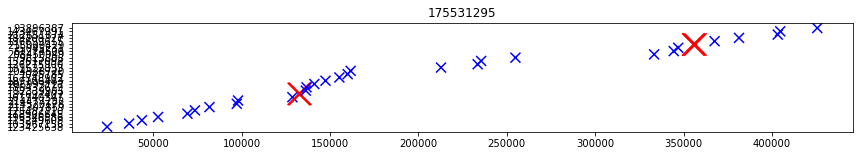

In [7]:
plot_shop("175531295")

# Forward window scanning
We process each shop independently.

Considering all possible windows is too time consuming, since there are 18770 shops and 6 days with 432000 seconds.

For each shop, we consider every order time as a possible starting time for the window. This is how the examples were presented in the instructions.

In [8]:
res = collections.defaultdict(set)
for current_shop_id, current_shop in tqdm(shops.items()):
    for i,(user,time) in enumerate(current_shop):
        start_time = time
        users = []
        for j,(user,time) in enumerate(current_shop[i:], start=i):
            if time > start_time + 3600:
                break
            users.append(user)
        score = len(users)//len(set(users))
        if score < 3:
            continue
        c = collections.Counter(users)
        maxc = max(c.values())
        res[current_shop_id].update([user for user in set(users) if c[user] == maxc])

In [9]:
shopids = []
userids = []
for k,v in res.items():
    shopids.append(str(k))
    userids.append("&".join(str(userid) for userid in sorted(v)))
    
df_detected = pd.DataFrame.from_dict({"shopid": shopids, "userid": userids})
df_detected = df_detected.set_index("shopid")

In [10]:
df_forward_brushing = df_sample_submission.copy()
df_forward_brushing = df_forward_brushing.set_index("shopid")
df_forward_brushing.update(df_detected)
df_forward_brushing = df_forward_brushing.reset_index()
print(scoring(df_forward_brushing))

Score: 0.88465
Suspicious shops correct/detected/total: 268/276/315
Suspicious shops multiuser correct/detected/total 3/9/9


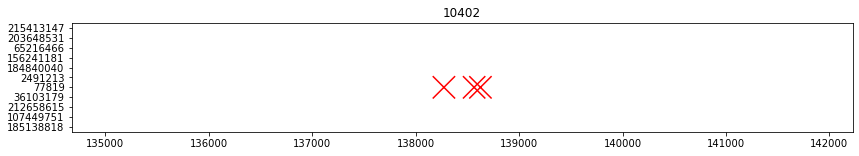

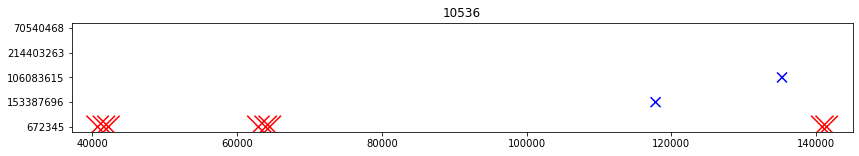

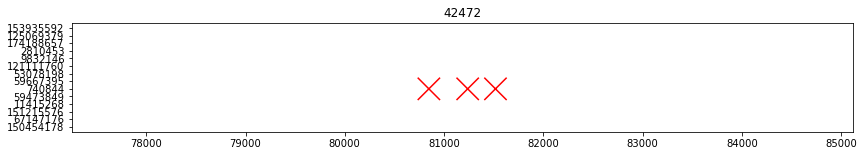

In [11]:
forward_shops = df_forward_brushing[(df_forward_brushing.userid != "0")]
for shop_id_inspected in forward_shops["shopid"][:3]:
    plot_shop(shop_id_inspected, limit_range=True)

Above are the shops that we have found with the scanning method.

# Backward window scanning

The above method misses out some suspicious shops.

For instance you have following sequence

userid|X|A|A|A|B|Y|
-|-|-|-|-|-|-|
time|00:00|08:30|08:31|08:32|09:01|12:00

<br>
The algorithm will consider the starting time as 08:30 and will not detect the suspicious period from 08:00 to 09:00.

We simply take the negative of the time, reverse the order of orders for each shop in our computation. We append suspicious users to our list.

In [12]:
for current_shop_id, current_shop in tqdm(shops.items()):
    for i,(user,time) in enumerate(current_shop[::-1]):  # reverse order of orders
        start_time = -time  # filp the sign of time
        users = []
        for j,(user,time) in enumerate(current_shop[::-1][i:], start=i):  # reverse order of orders
            time = -time  # filp the sign of time
            if time > start_time + 3600:
                break
            users.append(user)
        score = len(users)//len(set(users))
        if score < 3:
            continue
        c = collections.Counter(users)
        maxc = max(c.values())
        res[current_shop_id].update([user for user in set(users) if c[user] == maxc])

In [13]:
shopids = []
userids = []
for k,v in res.items():
    shopids.append(str(k))
    userids.append("&".join(str(userid) for userid in sorted(v)))
    
df_detected = pd.DataFrame.from_dict({"shopid": shopids, "userid": userids})
df_detected = df_detected.set_index("shopid")

In [14]:
df_birdirectional_brushing = df_sample_submission.copy()
df_birdirectional_brushing = df_birdirectional_brushing.set_index("shopid")
df_birdirectional_brushing.update(df_detected)
df_birdirectional_brushing = df_birdirectional_brushing.reset_index()
print(scoring(df_birdirectional_brushing))

Score: 0.96323
Suspicious shops correct/detected/total: 300/308/315
Suspicious shops multiuser correct/detected/total 3/11/9


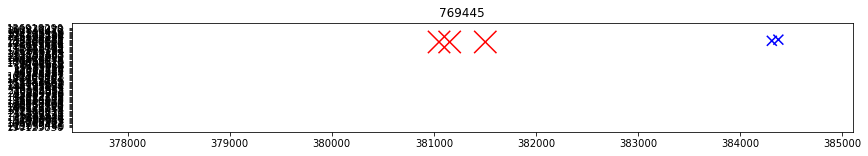

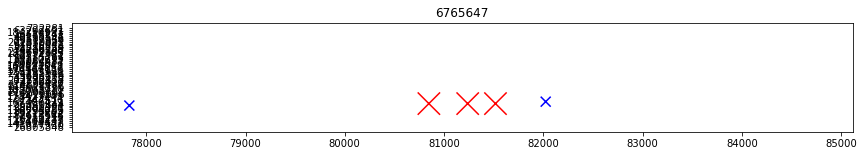

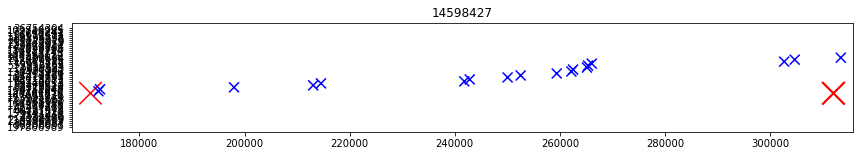

In [15]:
backward_shops = df_birdirectional_brushing[(df_birdirectional_brushing.userid != "0") & 
                                            (df_forward_brushing.userid == "0")]
for shop_id_inspected in backward_shops["shopid"][:3]:
    plot_shop(shop_id_inspected, limit_range=True)

Above are the additional shops that we have found. 

Note that not all highlighted orders suspicious as they can happen outside of the suspicious period.

# Finding the missing shops
However there are still some missing shops when we applied both methods. Here we visualise some of them.

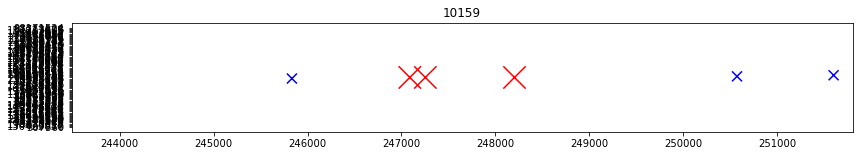

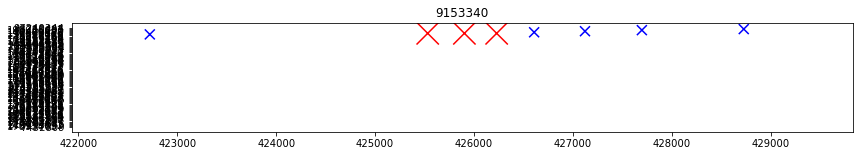

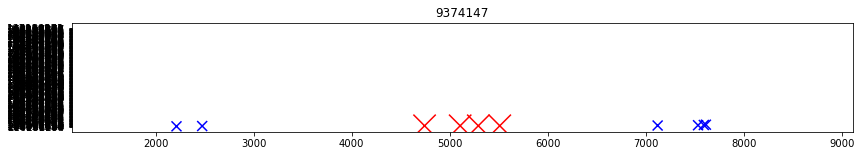

In [16]:
missing_shops = df_truth[(df_birdirectional_brushing.userid == "0") & (df_truth.userid != "0")]
for shop_id_inspected in missing_shops["shopid"][:3]:
    plot_shop(shop_id_inspected, limit_range=True)

It seems that the suspicious hour can start and end not exactly at an order time.

However, once again, considering all possible windows is too time consuming, since there are 18770 shops and 6 days with 432000 seconds.

Consider if you have following order sequence

userid|X|A|A|A|Y|
-|-|-|-|-|-|
time|07:59:59|08:30:00|08:31:00|08:32:00|09:00:01|

<br>

The suspicious hour starts happens from `08:00:00` to `09:00:00`, which is not one of the starting time. 

We consider the following as all possible start times
- every order time
- one second after every order time

We consider the following as all possible end times
- every order time
- one second before every order time

In [17]:
for current_shop_id, current_shop in tqdm(shops.items()):
    for i,(user,time) in enumerate(current_shop):
        start_time = time
        users = []
        for j,(user,time) in enumerate(current_shop[i:], start=i):
            if time > start_time + 3600:
                break
            if time == start_time:  # exclude current time
                continue
            users.append(user)
        if len(users) == 0:
            continue
        score = len(users)//len(set(users))
        if score < 3:
            continue
        c = collections.Counter(users)
        maxc = max(c.values())
        res[current_shop_id].update([user for user in set(users) if c[user] == maxc])

In [18]:
for current_shop_id, current_shop in tqdm(shops.items()):
    for i,(user,time) in enumerate(current_shop[::-1]):
        start_time = -time
        users = []
        for j,(user,time) in enumerate(current_shop[::-1][i:], start=i):
            time = -time
            if time > start_time + 3600:
                break
            if time == start_time:  # exclude current time
                continue
            users.append(user)
        if len(users) == 0:
            continue
        score = len(users)//len(set(users))
        if score < 3:
            continue
        c = collections.Counter(users)
        maxc = max(c.values())
        res[current_shop_id].update([user for user in set(users) if c[user] == maxc])

In [19]:
shopids = []
userids = []
for k,v in res.items():
    shopids.append(str(k))
    userids.append("&".join(str(userid) for userid in sorted(v)))
    
df_detected = pd.DataFrame.from_dict({"shopid": shopids, "userid": userids})
df_detected = df_detected.set_index("shopid")

In [20]:
df_delayed_brushing = df_sample_submission.copy()
df_delayed_brushing = df_delayed_brushing.set_index("shopid")
df_delayed_brushing.update(df_detected)
df_delayed_brushing = df_delayed_brushing.reset_index()
print(scoring(df_delayed_brushing))

Score: 0.98042
Suspicious shops correct/detected/total: 307/315/315
Suspicious shops multiuser correct/detected/total 3/11/9


We will write some code to make a submission

In [21]:
df_delayed_brushing.to_csv("submission.csv", index=False)
!head "submission.csv"

shopid,userid
10009,0
10051,0
10061,0
10084,0
10100,0
10107,0
10108,0
10110,0
10132,0


# Shops with multiple suspicious users

With the ground truth we see the shops with multiple suspicious users, and compare it with our current predictions.

In [22]:
df_pred_multiuser = df_delayed_brushing[df_delayed_brushing["userid"].str.contains("&")]
df_pred_multiuser.join(df_truth, how="left", rsuffix="_truth", lsuffix="_pred")

,shopid_pred,userid_pred,shopid_truth,userid_truth
990,8996761,13135622&137245836&162508227&215382704,8996761,215382704
3189,51134277,212200633&29857724,51134277,29857724&212200633
3194,51487211,214808165&5307816,51487211,5307816&214808165
3341,54257623,107414154&1974334,54257623,1974334&107414154
6456,107189025,159315857&35639374,107189025,35639374&159315857
8621,136564914,178491887&191211430,136564914,178491887
9045,143281052,186080843&99517130,143281052,99517130&186080843
9844,155143347,156202149&214265994,155143347,156202149&214265994
10024,156883302,136087303&187119675&188025647&68757133&76102350,156883302,76102350&188025647
13770,175531295,187697407&215009429,175531295,187697407&215009429


In [23]:
shop_id_inspected = "181009364"
shops[shop_id_inspected]

[('214208720', 1233),
 ('214208720', 1803),
 ('214208720', 3206),
 ('27847950', 91998),
 ('214515524', 125490),
 ('160784036', 168597),
 ('18028327', 173130),
 ('101832161', 222871),
 ('101832161', 222892),
 ('101832161', 222951),
 ('1646431', 284331),
 ('213441594', 317156),
 ('198488910', 333823),
 ('21653103', 390698),
 ('71990360', 395408),
 ('153128074', 417950)]

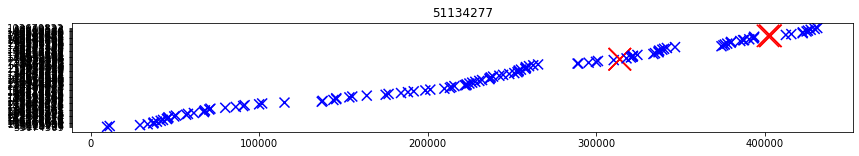

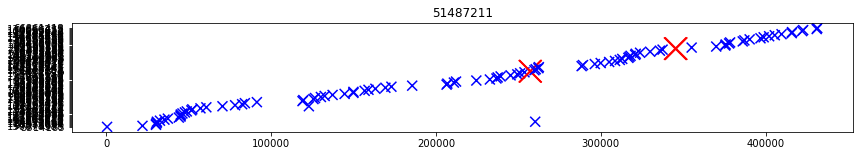

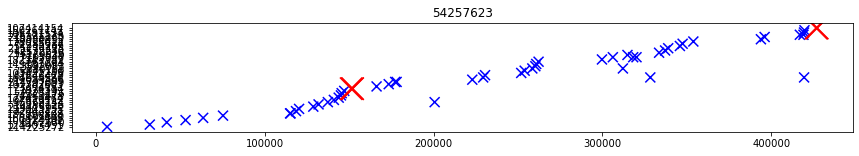

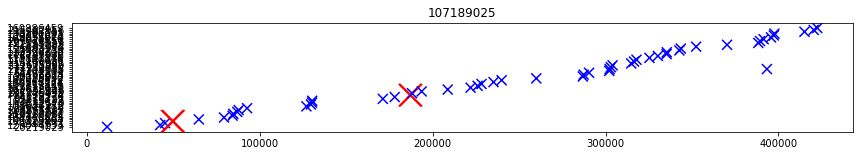

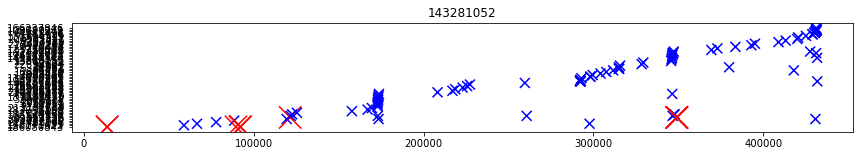

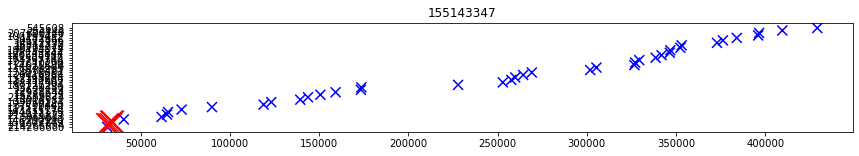

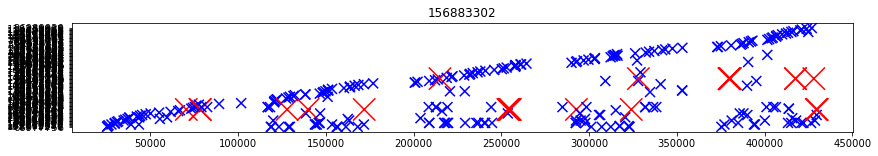

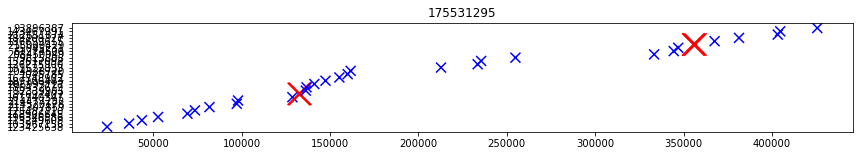

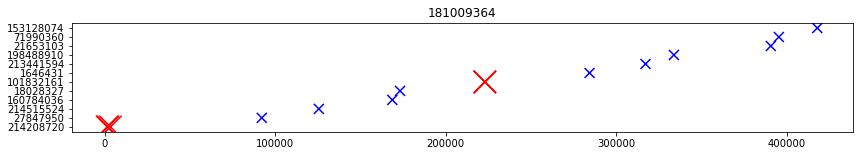

In [24]:
df_truth_multiuser = df_truth[df_truth["userid"].str.contains("&")]
for shop_id_inspected in df_truth_multiuser["shopid"]:
    plot_shop(shop_id_inspected)

The methods used in this notebook includes all potential suspicious buyers and does not consider rule 4. You might want to consult other resources that correctly interpret rule 4.

Since the number of shops is small, some of the group members check the entire list manually as well.





Hope this helps!

If you are interested in my work, you can also read about a notebook for a past Google Hashcode competition. https://www.kaggle.com/huikang/hc-2019q-eda-and-baseline-soln